In [ ]:
!pip install tensorflow==2.8
!pip install keras==2.8

In [1]:
import os
import numpy as np
from music21 import converter, pitch, interval, instrument, note, stream
from matplotlib import pyplot as plt

from xen.visualise import plotPart, plotSequence
from xen.data import getPartSequence, filterFractionalOffsets

data_dir = "../data/mutopia_guitar/"

scores = loadMidiScoresDir(data_dir)
scores = filterTimeSigOnly(scores, (4,4))
scores = filterFractionalOffsets(scores) # remove scores with triplets
print(f'Loaded {len(scores)} Songs') 


Ignoring .DS_Store
Ignoring giuliani-op15-mids.zip
Ignoring bwv-988-guitar-mids.zip
Ignoring sorf-op45n03-mids.zip
Ignoring AguadoOp4No1-mids.zip
Ignoring grande-sonate-mids.zip
Ignoring TwoMinorPreludes-mids.zip
Ignoring air-varie-mids.zip
Ignoring SixVariations-mids.zip
Ignoring AguadoOp4No2-mids.zip
Ignoring rialto_ripples-mids.zip
Loaded 75 Songs


(4, 64, 128)
(8, 64, 128)
(5, 64, 128)
(10, 64, 128)
(3, 64, 128)
(3, 64, 128)
(3, 64, 128)
(3, 64, 128)
(2, 64, 128)
(7, 64, 128)
(7, 64, 128)
(8, 64, 128)
(8, 64, 128)
(3, 64, 128)
(2, 64, 128)
(5, 64, 128)
(5, 64, 128)
(3, 64, 128)
(4, 64, 128)
(4, 64, 128)
(4, 64, 128)
(3, 64, 128)
(3, 64, 128)
(1, 64, 128)
(2, 64, 128)
(3, 64, 128)
(3, 64, 128)
(4, 64, 128)
(9, 64, 128)
(6, 64, 128)
(6, 64, 128)
(4, 64, 128)
(4, 64, 128)
(12, 64, 128)
(3, 64, 128)
(6, 64, 128)
(4, 64, 128)
(8, 64, 128)
(8, 64, 128)
(7, 64, 128)
(2, 64, 128)
(2, 64, 128)
(2, 64, 128)
(8, 64, 128)
(3, 64, 128)
(4, 64, 128)
(11, 64, 128)
(5, 64, 128)
(8, 64, 128)
(5, 64, 128)
(3, 64, 128)
(11, 64, 128)
(1, 64, 128)
(2, 64, 128)
(3, 64, 128)
(4, 64, 128)
(9, 64, 128)
(6, 64, 128)
(3, 64, 128)
(3, 64, 128)
(3, 64, 128)
(3, 64, 128)
(4, 64, 128)
(6, 64, 128)
(11, 64, 128)
(1, 64, 128)
(11, 64, 128)
(7, 64, 128)
(11, 64, 128)
(11, 64, 128)
(12, 64, 128)
(3, 64, 128)
(3, 64, 128)
(4, 64, 128)
(3, 64, 128)
(6, 64, 128)
(4,

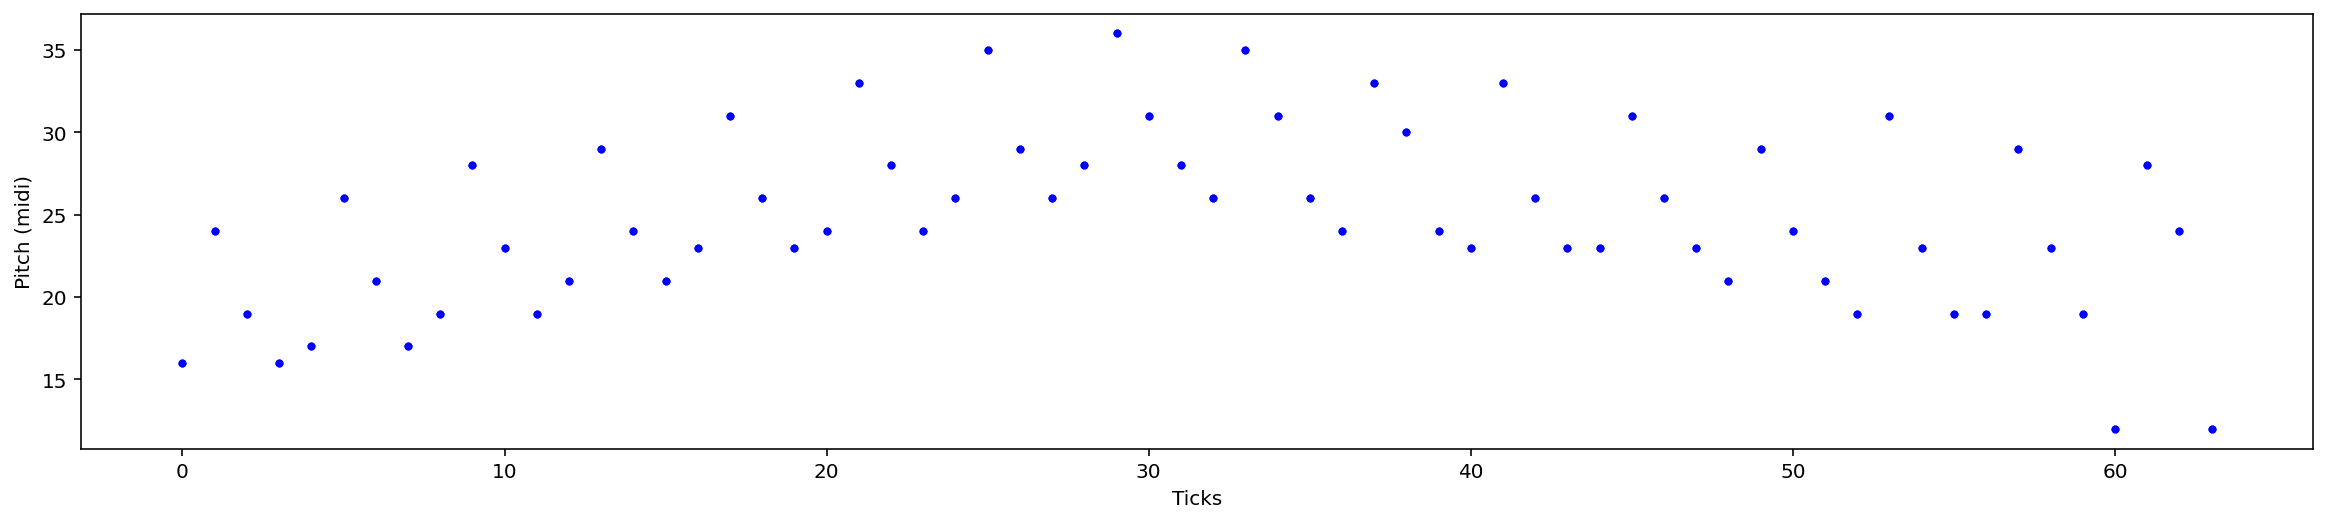

In [2]:
sequences = []

ticksPerQuarter = 4   # 4 = 16th notes, to allow triplets would need to be 12 = 48 per measure
measureLength = ticksPerQuarter * 4
measuresPerSequence = 4
sequenceLength = measureLength*measuresPerSequence
midiNotes = 128
sequences = np.empty((0, sequenceLength, midiNotes), int)

minPitch = 127
maxPitch = 0
for i, score in enumerate(scores):
    try:
        for part in score.getElementsByClass(stream.Part):
            seqs, seqMin, seqMax = getPartSequences(part, ticksPerQuarter, measuresPerSequence)
            sequences = np.append(sequences, seqs, 0)
            minPitch = min(minPitch, seqMin)
            maxPitch = max(maxPitch, seqMax)
    except Exception as e:
        print(f'File: {score.filePath}')
        print(f'Error: {str(e)}')
        

trainInput = np.array(sequences)
trainInput = trainInput[0:, 0:, minPitch:maxPitch+1]  # remove unused pitch classes

numSequences = trainInput.shape[0]
sequenceLength = trainInput.shape[1]
numCategories = trainInput.shape[2] #Category per midi note

print(trainInput.shape) # sequences, sequence length, pitch classes

flatTrainInput = trainInput.reshape(numSequences, sequenceLength * numCategories)

print(flatTrainInput.shape)
# print(flatTrainInput)

inputShape = (flatTrainInput.shape[1])

plotSequence(trainInput[1])


In [6]:
import tensorflow as tf

inputShape = inputShape
latentShape = (2)

# encoder model
encoderInput = tf.keras.layers.Input(shape = inputShape)
encoderOutput = tf.keras.layers.Dense(latentShape, activation = 'tanh')(encoderInput)
encoder = tf.keras.Model(encoderInput, encoderOutput)

# decoder model
decoderInput = tf.keras.layers.Input(shape = latentShape)
decoderOutput = tf.keras.layers.Dense(inputShape, activation = 'sigmoid')(decoderInput)
decoder = tf.keras.Model(decoderInput, decoderOutput)

# autoencoder model
autoencoder = tf.keras.Model(encoderInput, decoder(encoderOutput))

In [13]:

autoencoder.compile(loss = 'binary_crossentropy', optimizer='rmsprop')

autoencoder.fit(flatTrainInput, flatTrainInput, epochs = 50)


Epoch 1/50
13/13 [==============================] - 1s 4ms/step - loss: 0.0627
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0627
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0627
Epoch 8/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0627
Epoch 9/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0627
Epoch 10/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0627
Epoch 11/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0627
Epoch 12/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0627
Epoch 13/50
13/13 [==============================

In [15]:
input = np.array([flatTrainInput[0]])

output = autoencoder.predict(input)

output = output.reshape(1, sequenceLength, numCategories)

print(output.shape)
print(output)

(1, 64, 52)
[[[6.5851510e-03 3.0556210e-05 7.9710752e-02 ... 3.0494377e-05
   3.0542924e-05 1.7538965e-03]
  [3.0544263e-05 3.0458976e-05 3.0555948e-05 ... 3.0583789e-05
   3.0339244e-05 3.0458539e-05]
  [3.0664600e-05 3.0582069e-05 1.7437339e-03 ... 3.0415029e-05
   3.0630170e-05 3.0526440e-05]
  ...
  [3.0547817e-05 3.0665829e-05 3.0497460e-05 ... 3.0497722e-05
   3.0494144e-05 3.0515788e-05]
  [3.0400644e-05 3.0600506e-05 6.4698458e-03 ... 3.0494959e-05
   3.0656764e-05 3.0603744e-05]
  [3.0413463e-05 3.0397920e-05 4.0878952e-03 ... 3.0640716e-05
   3.0575971e-05 3.0485362e-05]]]
